# Estimating stability using DTS

__Problem statement__:

Temperature gradients are a fundamental atmospheric property. However, they are always estimated using (often very) limited point observations at fixed heights. Most commonly these are two thermometers with some fixed distance between the sensors. Sensors with a slow response time are generally more accurate and used for these purposes. Therefore we have: limited and fixed spatial resolution and coarse temporal resolutions relative to Distributed Temperature Sensing (DTS). With vertical profiles of DTS giving fine resolution (1s, 0.1m) temperature observations, we have the opportunity to resolve these gradients in detail for the first time.


Goals of the notebook:
- robustly model stability using a Bayesian Generalized Linera Models (GLM). See section 5.
- determine appropriate Bayesian hyperparameters and parameters for the GLMs. See section 4.
- prototype how this linear modeling can be compared to Monin-Obukhov Similarity Theory. See sections 4.2.3 and 5.4.

# 1. Import and formatting

In [1]:
# Data and methods libraries
import numpy as np
import xarray as xr
import scipy.stats
import pandas as pd

# OS interaction
import os

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import datetime
import copy
import pymc3 as pm
import warnings

## Format plots

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Define a default color palette, which should be fairly color blind friendly). The
# last purple is a bit similar to the blue for red blindness.
flatui = ["#3498db", "#FFBF00", "#34495e", "#95a5a6", "#e74c3c", "#9b59b6",]
sns.set_palette(sns.color_palette(flatui))

## Directories

In [3]:
dir_pre = os.path.join('/Users/karllapo/Dropbox/DarkMix/proj/DarkMix_Voitsumra/')

# Meteorological data
dir_logger_data = os.path.join(dir_pre, 'logger_data')
dir_aws_data = os.path.join(dir_logger_data, 'AWS')
dir_csat_stats = os.path.join(dir_logger_data, 'CSATs', 'stats')
dir_csat_flux = os.path.join(dir_logger_data, 'CSATs', 'fluxes')
dir_csat_corr = os.path.join(dir_logger_data, 'CSATs', 'csat-Ts-correction')
dir_ceil = os.path.join(dir_pre, 'love_dts/ESSD-repository/remote-sensing/ceilometer/')
dir_homogenized_data = os.path.join(dir_pre, 'homogenized_data')

# Figures
dir_print = os.path.join(dir_pre, 'figures', 'AncillaryMet')


# 2. Load data

## 2.1 Homogenized potential temperature data

In [4]:
os.chdir(dir_homogenized_data)

sonic_1min = xr.open_dataset('sonics_pot-temp_1min_qc_tower-subset.v2-2021-06-01.nc')
sonic_10min = xr.open_dataset('sonics_pot-temp_10min_qc_tower-subset.v2-2021-06-01.nc')
aws_2m_theta = xr.open_dataset('aws_pot-temp_1min_qc_tower-subset.v2-2021-06-01.nc')
aws_2m_theta_10min = xr.open_dataset('aws_pot-temp_10min_qc_tower-subset.v2-2021-06-01.nc')
tower = xr.open_dataset('tower_pot-temp_1s_qc_tower-subset.v2-2021-06-01.nc')
tower_1min = xr.open_dataset('tower_pot-temp_1min_qc_tower-subset.v2-2021-06-01.nc')
tower_10min = xr.open_dataset('tower_pot-temp_10min_qc_tower-subset.v2-2021-06-01.nc')

## 2.2 Ancillary data

Ceilometer and the automatic weather station

- Ceilometer for cloudiness
- AWS for radiation and RH

In [6]:
os.chdir(dir_ceil)
ceilo = xr.open_dataset('ceiolometer-combined-files_2019_June01-Aug15.nc')
ceilo = ceilo.reindex_like(sonic_1min.time, method='nearest')

In [7]:
os.chdir(dir_aws_data)
aws = xr.open_dataset('AWS_Voi_1min.nc')

# 3. Temperature Gradients

The fundamental quantity for temperature gradients is $\frac{dT}{dz}$

## 3.1 Generate a time series of ols log-linear fitting

In [8]:
# Pre-allocate the ols parameters in the 10 min tower Dataset
tower_10min['ols_m'] = (('time'), np.zeros(len(tower_10min.time.values)))
tower_10min['ols_r'] = (('time'), np.zeros(len(tower_10min.time.values)))
tower_10min['ols_p'] = (('time'), np.zeros(len(tower_10min.time.values)))
tower_10min['ols_b'] = (('time'), np.zeros(len(tower_10min.time.values)))

z_range = np.arange(0.5, 12, 0.25)

for t in tower_10min.time:
    ds_tower = tower_10min.sel(time=t).theta_mean

    result_dts = scipy.stats.linregress(np.log(ds_tower.z), ds_tower.values)
    tower_10min['ols_m'].loc[{'time': t}] = result_dts.slope
    tower_10min['ols_r'].loc[{'time': t}] = result_dts.rvalue
    tower_10min['ols_p'].loc[{'time': t}] = result_dts.pvalue
    tower_10min['ols_b'].loc[{'time': t}] = result_dts.intercept

### 3.1.1 Quickly visualize the time series of ols log-linear slopes

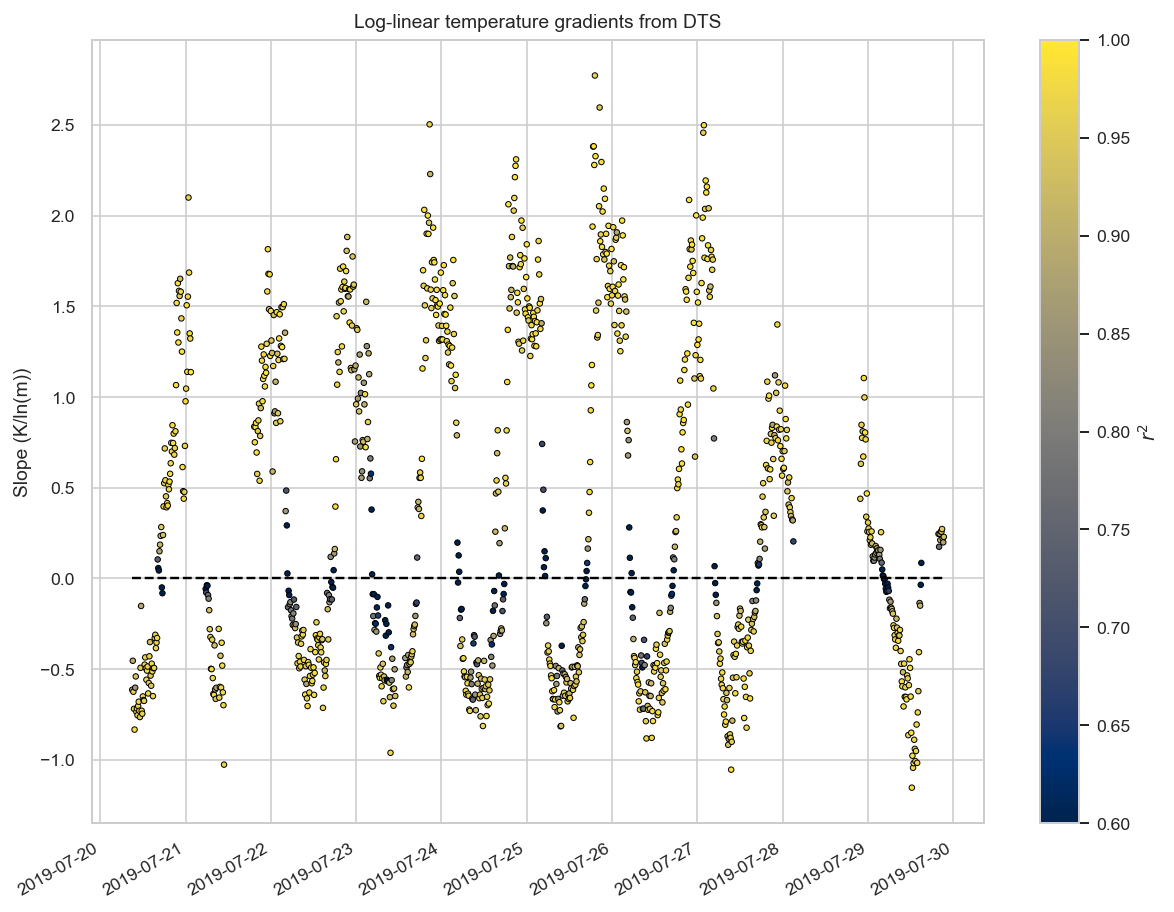

In [9]:
plt.figure(figsize=(10, 8))
im = plt.scatter(
    tower_10min.time.values,
    tower_10min.ols_m.values,
    30,
    tower_10min.ols_r.values ** 2,
    marker='.', 
    cmap='cividis',
    vmin=0.6,
    vmax=1,
    edgecolor='k',
    linewidth=0.5
)
plt.plot([tower_10min.time.values[0], tower_10min.time.values[-1]], [0, 0], 'k--')
plt.gca().set_ylabel('Slope (K/ln(m))')
plt.gca().set_title('Log-linear temperature gradients from DTS')
cbar = plt.gcf().colorbar(im)
cbar.set_label('$r^2$')
plt.gcf().autofmt_xdate()

The distribution of $R^2$ towards periods with a slope of zero (neutral conditions) makes some sense, as the slope is zero. But, it also suggests that we need a better linear fit algorithm. Let's briefly investigate if that is the case.

### 3.1.2 Visualizing the temperature gradients with the poorer fit

I'll just use a random subset of 9 of the 10 min intervals to see what sort of features drive the poorer linear relationships ($R^2 < 0.8$)

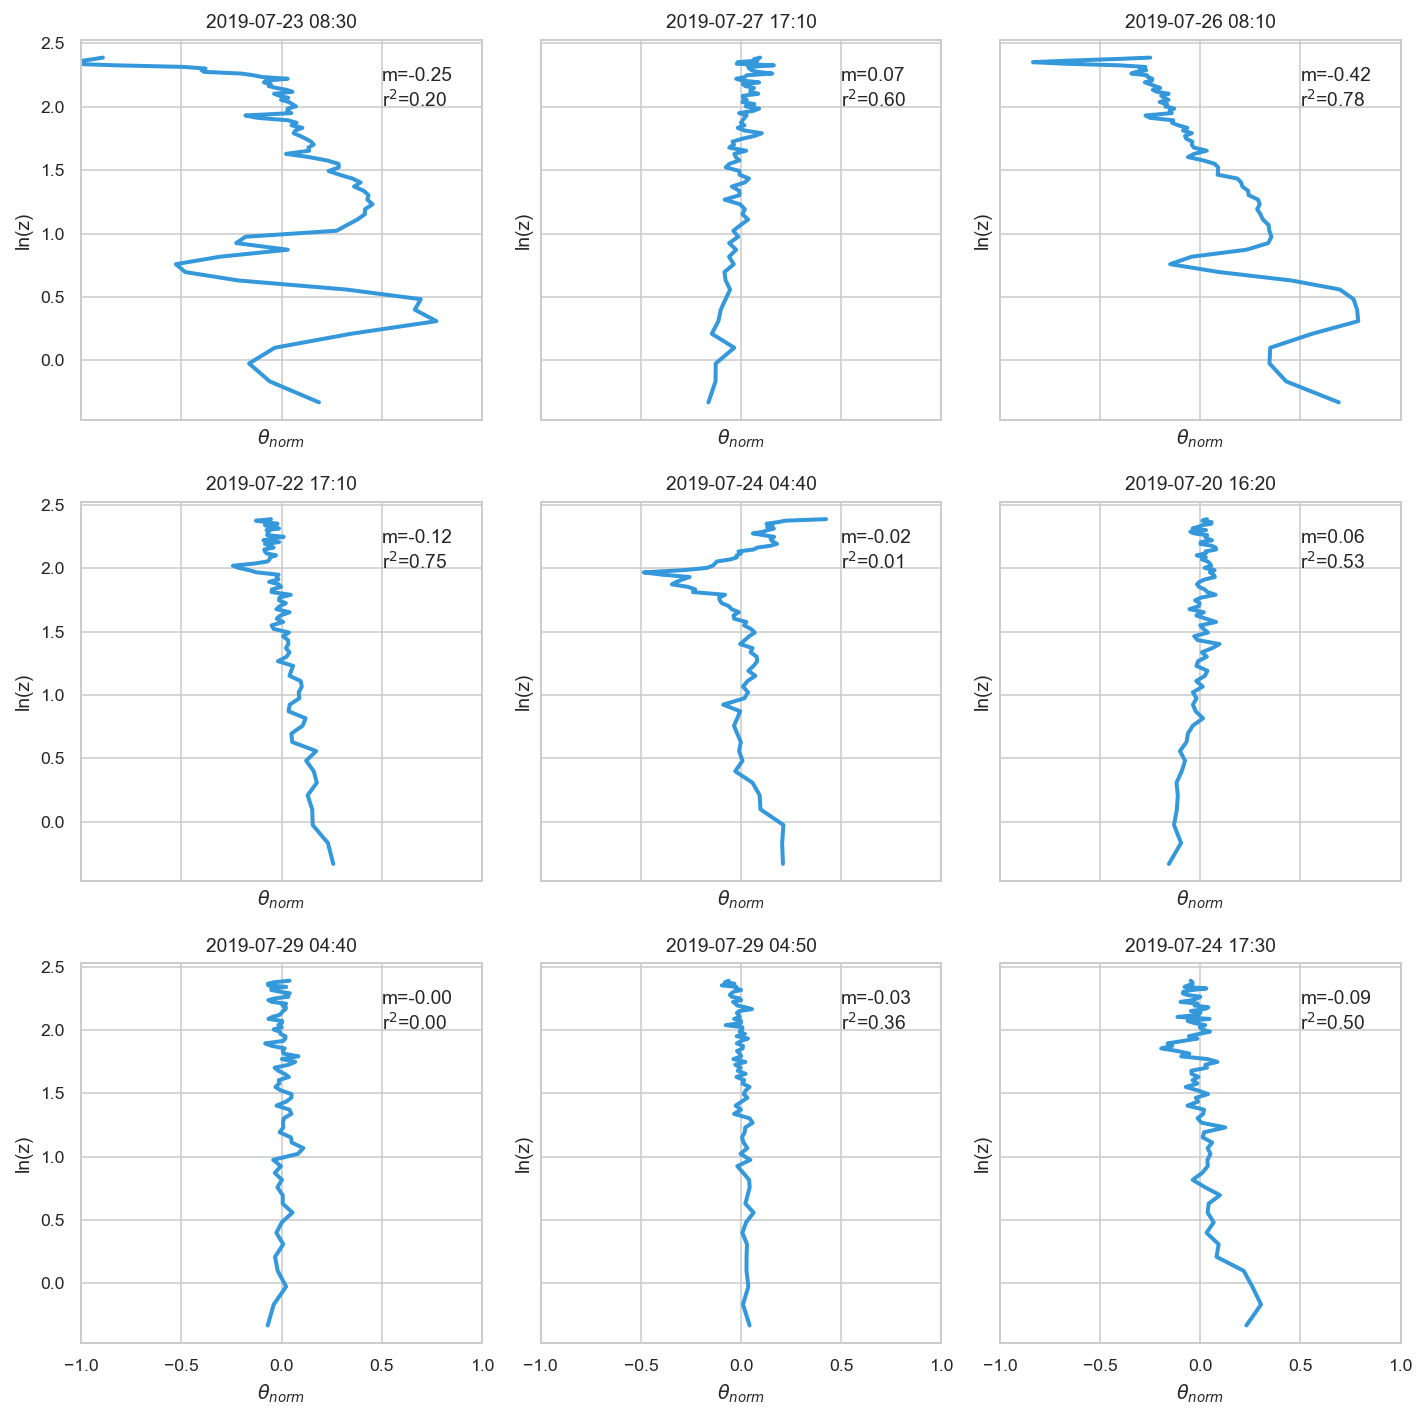

In [10]:
from numpy.random import default_rng


ind = (tower_10min.ols_r ** 2) < 0.8
ds = tower_10min.where(ind, drop=True)

rng = default_rng()
samp = rng.choice(len(ds.time.values), size=9, replace=False)

fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(10, 10))
axes = axes.flatten()
for ns, n in enumerate(samp):
    ax = axes[ns]
    dt = pd.Timestamp(ds.isel(time=n).time.values)
    ds_plot = ds.isel(time=n)
    ax.plot(ds_plot.theta_mean_norm, ds_plot.lnz.values, linewidth=2)
    ax.set_title(dt.strftime('%Y-%m-%d %H:%M'))
    ax.set_ylabel('ln(z)')
    ax.set_xlabel(r'$\theta_{norm}$')
    ax.set_xlim(-1, 1)
    ax.text(0.5, 2, 'm={:0.2f}\nr$^2$={:0.2f}'.format(ds_plot.ols_m.values, ds_plot.ols_r.values**2))
fig.tight_layout()

Many of the poorer fits seem to be related to periods with obvious layering and stronger stability/instability. The other periods are clearly periods with a slope of 0.

Let's just check the poorer linear fits that are near neutral. Here I select the stability based on having a slope near zero during periods with cloud cover. 

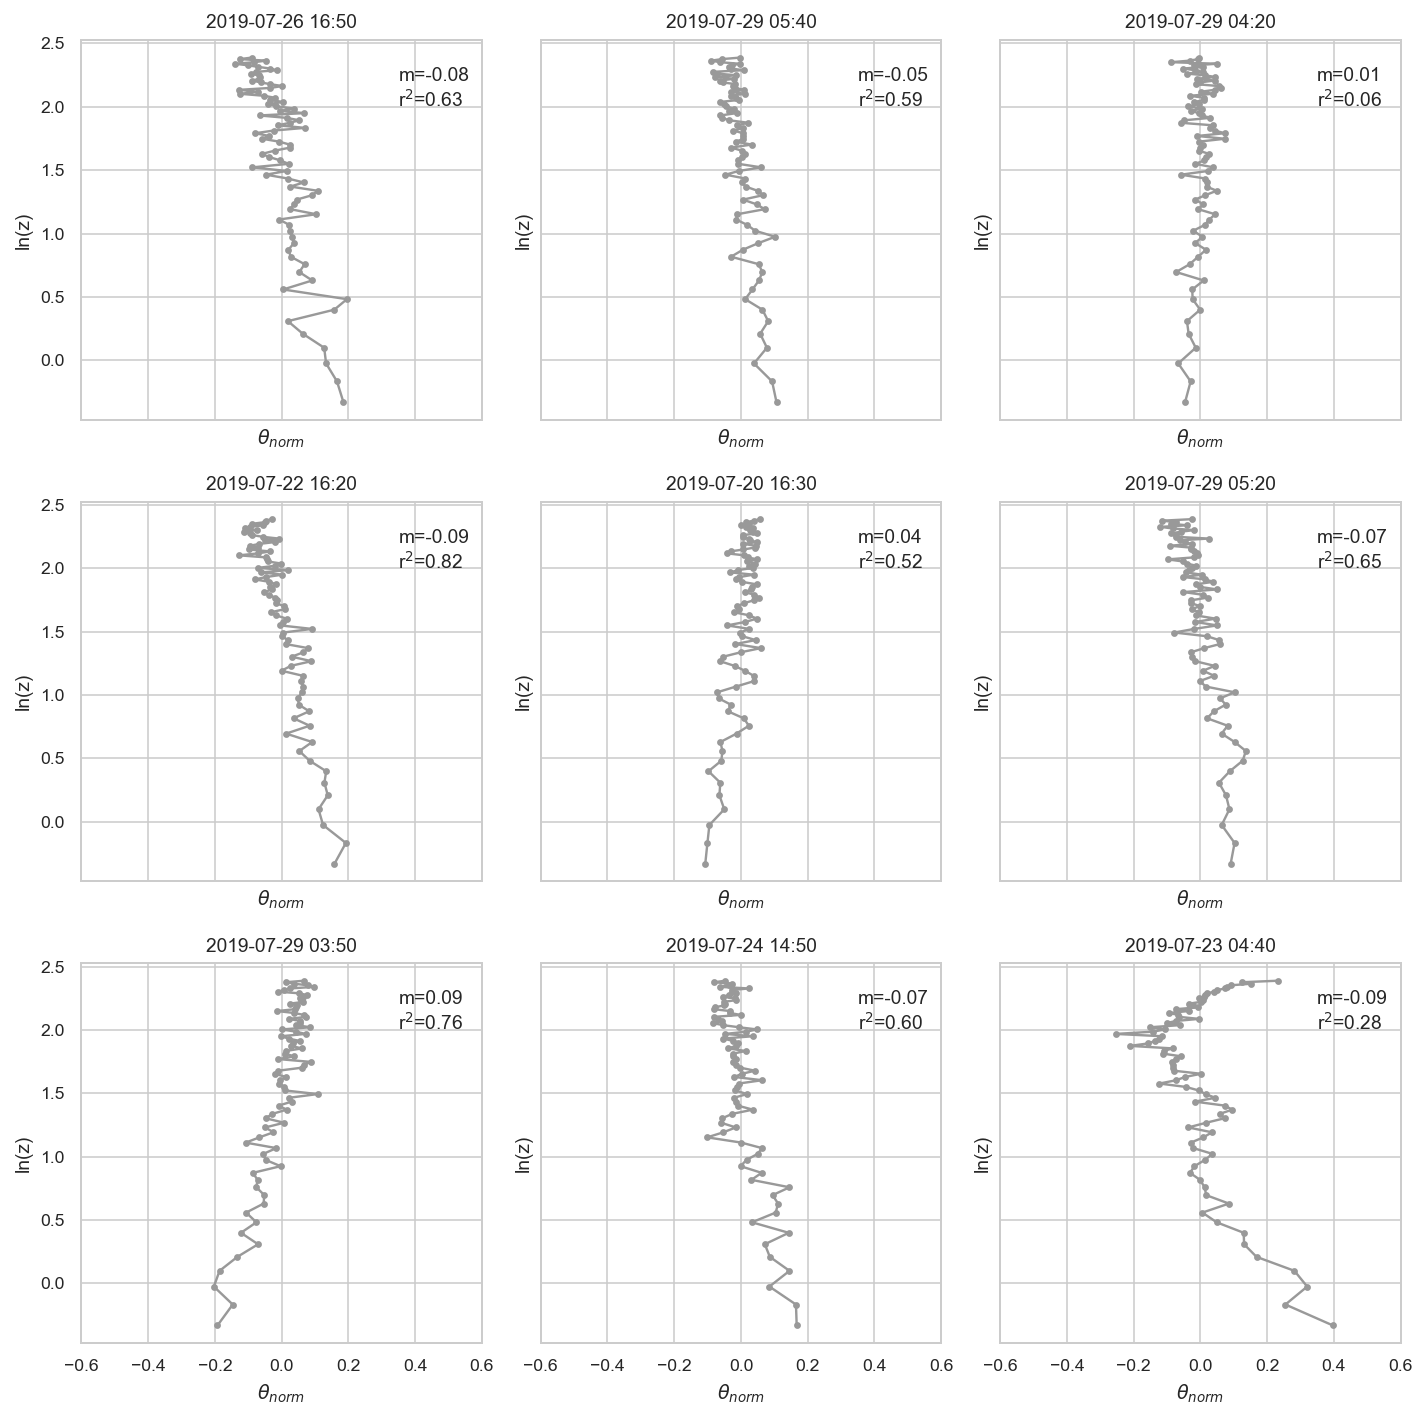

In [11]:
ind = (tower_10min.ols_m < 0.1) & (tower_10min.ols_m > -0.1)
ds = tower_10min.where(ind, drop=True)

rng = default_rng()
samp = rng.choice(len(ds.time.values), size=9, replace=False)

fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(10, 10))
axes = axes.flatten()

for ns, n in enumerate(samp):
    ax = axes[ns]
    
    dt = pd.Timestamp(ds.isel(time=n).time.values)
    ds_plot = ds.isel(time=n)
    
    ax.plot(ds_plot.theta_mean_norm, ds_plot.lnz.values, color='0.6', marker='.')
    ax.set_title(dt.strftime('%Y-%m-%d %H:%M'))
    ax.set_ylabel('ln(z)')
    ax.set_xlabel(r'$\theta_{norm}$')
    ax.set_xlim(-0.6, 0.6)
    ax.text(0.35, 2, 'm={:0.2f}\nr$^2$={:0.2f}'.format(ds_plot.ols_m.values, ds_plot.ols_r.values**2))

fig.tight_layout()

Often these "neutral" periods actually have layering present. Only some of the periods are actually neutral. Discriminating these two scenarios is of major scientific interest.

# 4. Bayesian linear regression with likelihood outlier classification

Bayesian Generalized Linear Models give well-defined parameter uncertainty and confidence intervals. As part of the GLM I can use the Hogss inlier classifier for points that are in-liers vs outliers. The implication of adequately implementing such a model means I can more robustly determine the log-linear slope, intercept, and artifacts/similarity theory violating periods, in addition to how far the sonic potential temperature is from the neutral boundary layer profile. See the above profiles for an example of why that matters. Note how there are certain obvious features that do not fit within the linear profile.

## 4.1 Relating $\frac{dT}{dz}$ to theory

The GLM can be used to directly model and test similarity theory. Here we can use:

$T(z) =  T(z=z_{0}) + \frac{\theta*}{k}\left\{\frac{\ln{z}}{\ln{z_T}} - \psi \left( \frac{\ln{z}}{\ln{L}} \right) \right\}$

where $\theta*=\frac{\overline{wT}}{u*}$, the normalized sensible heat flux, $z_T$ is the scalar roughness length scale for temperature, $L$ is the Obukhov length scale, and $\psi$ is the stability correction, and $k$ is the von Karman constant.

For neutral conditions, the second term in the brackets disappears, meaning that the slope of the GLM should be $\frac{\theta*}{k\ln{z_0}}$ and the intercept should be:

$b_{0} = T(z=z_{0}) - \frac{\theta*}{k\ln{z_T}}$

Unfortunately, in $\ln{z}$ space the intercept actually occurs at ~1m height. We can feed that directly into the model, but it somewhat limits the inference of the more interesting physical quantity, $T(z=z_T)$, directly from model parameters. Fortunately, this term is usually fairly small and can be estimated using a number of different parameterizations. Here I will use the Yang 2008 parameterization included in the Noah LSM.

All of this is to say I actually have well-informed priors for the slope and offset that can be used to inform the Bayesian GLM.

## 4.2 Model Priors


### 4.2.1. Estimate uncertainty at the 10 minute scale for the DTS data

I want to use periods that are near neutral to get a sense of the distribution. I choose neutral conditions with the linear fit, as it should allow a derivation of the distribution of points without any stability trend interfering. This is only weakly true, so some long-tail distribution is likely most appropriate for representing the distribution of DTS points.

####  Standardizing the data?

While the literature on Bayesian GLM stress the importance of standardizing the data, this comes with the cost of removing the physical meaning for the coefficients. As the physical meaning is what allows me to inform the priors, I opt to not use any standardizing. 

I need to provide uncertainty estimates on the observations. When aggregating to 10minutes I took the standard deviation for each time-space bin. However, I do not believe this is an accurate estimate of observation uncertainty, since this includes the effect of non-stationarity. The below plot shows that the standard deviation can become very high at certain times and heights, likely reflecting a real physical process that is of interest.

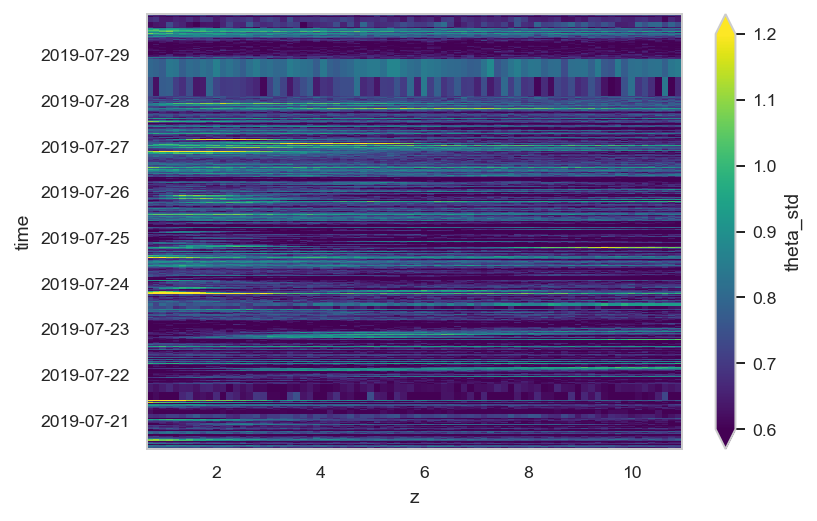

In [12]:
tower_10min.swap_dims({'xyz': 'z'}).theta_std.plot(vmin=0.6, vmax=1.2)

### 4.2.2 Model priors when enforcing stationarity

Instead let's look at a period where I can more safely assume (temporal) stationarity by using neutral conditions. The ols linear fits will inform this decision making.

To give less strict priors I will use a "neutral" cut-off of 0.1K/m instead of 0.04K/m. 

On a related note, what are the the units of the gradient when using the semilog profile? K/ln(m)?

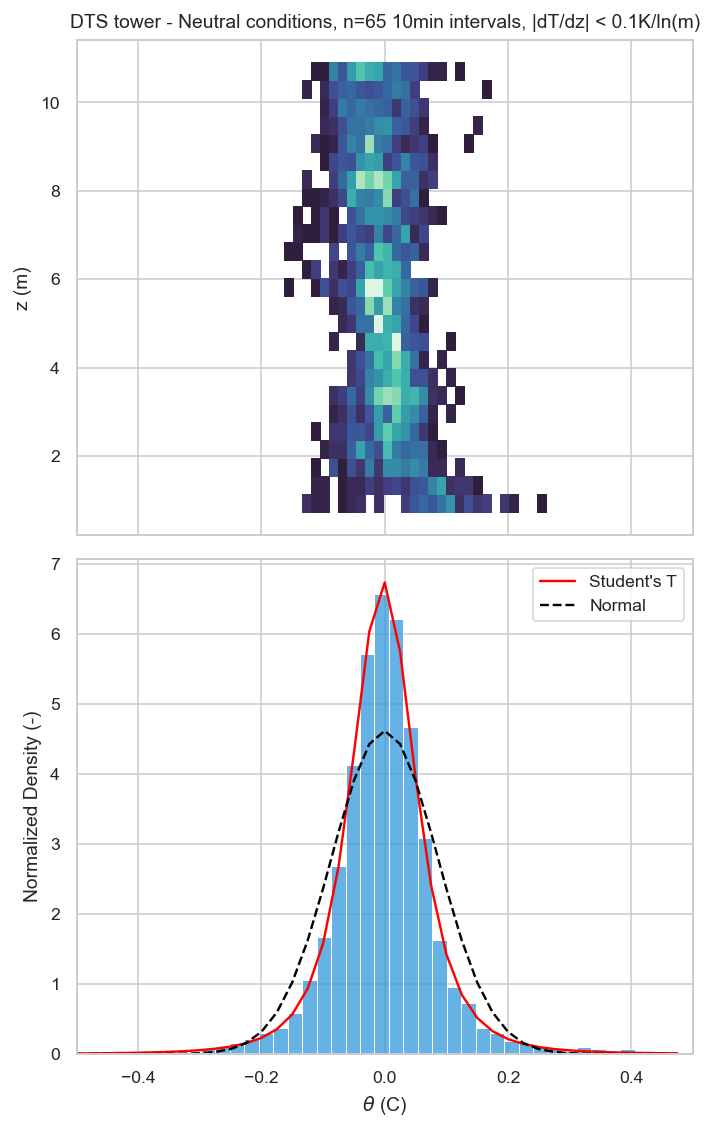

In [13]:
sns.set_context('paper')

ind = (tower_10min.ols_m > -0.1) & (tower_10min.ols_m < 0.1)
ds = tower_10min.where(ind, drop=True)

z = ds.z.values
z, _ = np.meshgrid(z, ds.time.values)
z = np.array(z)
samp = ds['theta_mean_norm'].values.flatten()

fig, axes = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
ax = axes[0]
sns.histplot(x=samp, y=z.flatten(), bins=(80, 25), pthresh=.1, cmap="mako", ax=ax)
ax.set_ylabel('z (m)')

ax = axes[1]
x = np.arange(-0.5, 0.5, 0.025)

# Student-t fit
param_studentt = scipy.stats.t.fit(samp)
pdf_fitted_studentt = scipy.stats.t.pdf(x, loc=param_studentt[1], scale=param_studentt[2], df=param_studentt[0])

# Normal gaussian
param_guass = scipy.stats.norm.fit(samp)
pdf_fitted_guass = scipy.stats.norm.pdf(x, loc=param_guass[0], scale=param_guass[1])

ax.plot(x, pdf_fitted_studentt,'r-', label='Student\'s T')
ax.plot(x, pdf_fitted_guass,'k--', label='Normal')

sns.histplot(x=ds['theta_mean_norm'].values.flatten(), bins=(50), ax=ax, stat='density')
ax.set_ylabel('Normalized Density (-)')
ax.set_xlabel(r'$\theta$ (C)')
ax.set_xlim(-0.5, 0.5)
ax.legend()
axes[0].set_title('DTS tower - Neutral conditions, n={} 10min intervals, |dT/dz| < {}K/ln(m)'.format(ind.sum().values, 0.1))
fig.tight_layout()

In [14]:
print('df={}, loc={}, scale={}'.format(param_studentt[0], param_studentt[1], param_studentt[2]))

df=3.053390435630643, loc=-0.0023708708481033312, scale=0.05457303519244836


Using the neutral data, it is pretty clear that the DTS data is better described by a Student's t-distribution and is not normally distributed. I will be informing the priors for the observational uncertainty in the Bayesian GLM using the Student's t-distribution instead of a normal distribution.

Standard deviation is much less than the value calculated for the 10 min aggregations. For comaprison I will also do a GLM using assuming a normally distributed prior. For the std in this case I'm going to go with 0.15K as my weakly informative prior.

### 4.2.3 Priors for slope and surface roughness scale for temperature

The intercept should be the surface temperature. But, first, define the data set for the linear fitting. I am selecting an interesting case in which we have two distinct sublayers.

Text(0, 0.5, '$\\theta$ (C)')

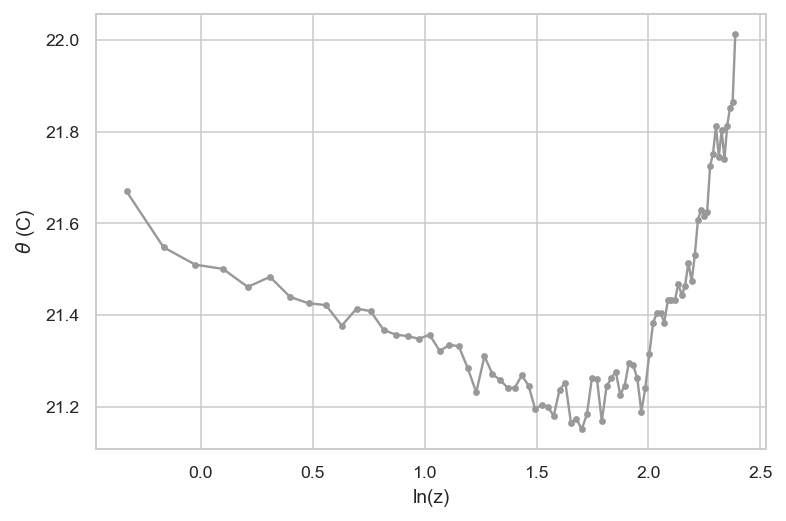

In [16]:
t_interest = pd.Timestamp('2019-07-27 04:50')

ds_bayes_GLM = tower_10min.sel(time=t_interest)
ds_sonic = sonic_10min.sel(time=t_interest)

# And plot it
ds_bayes_GLM["sigma_theta"] = 0.15
plt.plot(
    ds_bayes_GLM.lnz,
    ds_bayes_GLM.theta_mean,
    color='0.6',
    marker='.')
plt.gca().set_xlabel('ln(z)')
plt.gca().set_ylabel(r'$\theta$ (C)')

#### Estimate the surface roughness length for temperature

We can use something like the below function to estimate the surface roughness length for temperature.

In [17]:
def yang_08(ustar, tstar, z0Ground, airTemp, mHeight):
    '''
    As implemented in NoahMPv1.1
    '''
    if np.max(airTemp) < 200:
        airTemp = airTemp + 273.15
    
    # Constants
    beta = 7.2  # m^(-1/2) s^(1/2) K^(-1/4)
    m = 0.5
    n = 0.25
    # Kinematic viscosity (as estimated in Andreas 1987)
    kinvisc = (1. * 10.**7. / (.9065 * airTemp - 112.7)) ** (-1.)

    z0Ground = 70 * kinvisc / ustar * np.exp(-beta * ustar**(m)
                                             * np.abs(tstar)**(n))
    z0Groundh = z0Ground
    z0Groundq = z0Ground

    # Log profiles
    dlogT = np.log(mHeight / z0Groundh)
    dlogQ = np.log(mHeight / z0Groundq)

    return (z0Groundh, z0Groundq, dlogQ, dlogT)

In [18]:
# From processing the CSAT observations using typical micrometeorological approaches
z0 = 0.366667

z0_t_est, _, _, _ = yang_08(
    ds_sonic['u*'].sel(names='1m').values,
    ds_sonic.wTs.sel(names='1m').values,
    z0,
    ds_bayes_GLM.theta_mean.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest').values,
    1.)
print(z0_t_est)

0.019491889362988107


### Compare DTS temperature profile metrics to observed turbulence properties 

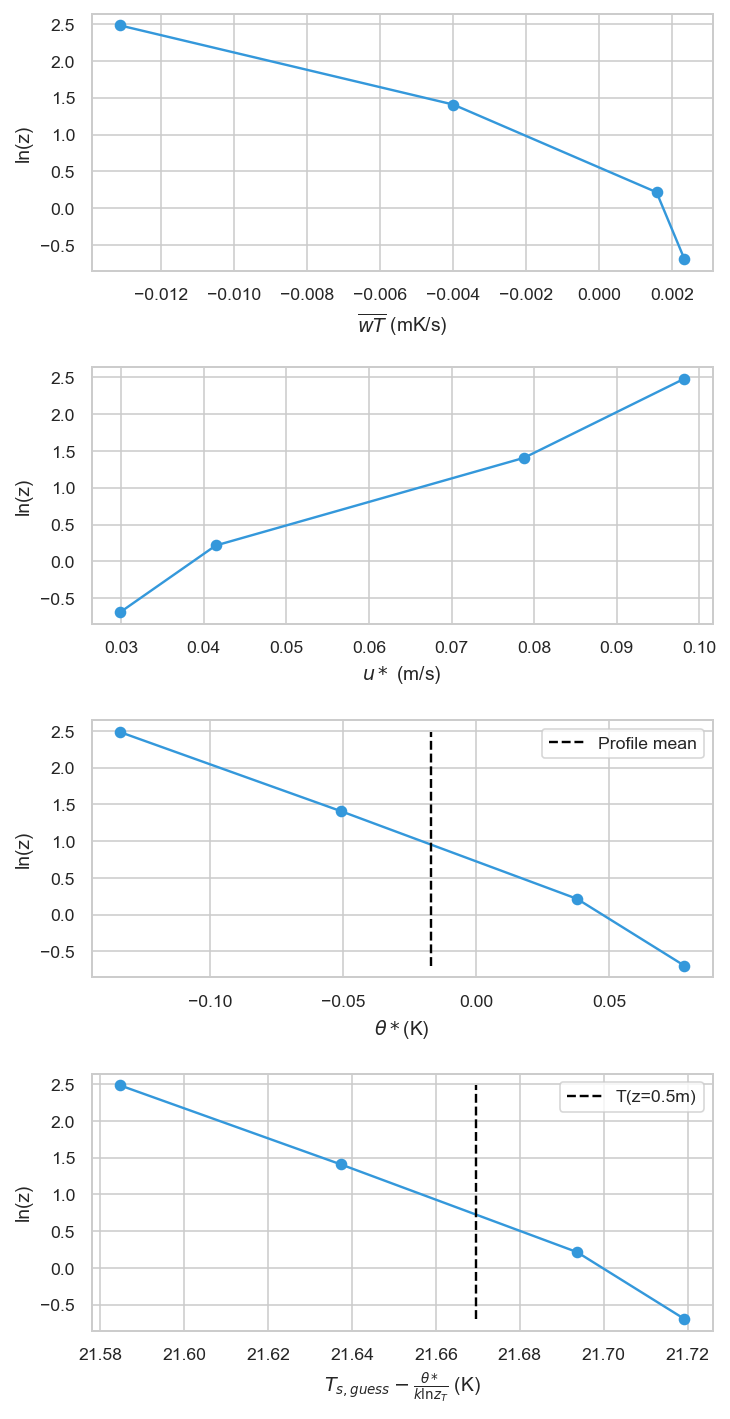

In [19]:
theta_star = (ds_sonic.wTs / ds_sonic['u*'])
theta_star_profile_avg = theta_star.mean(dim='names').values

b0_most = ds_bayes_GLM.theta_mean.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest') - theta_star / (0.4 * np.log(z0_t_est))

fig, axes = plt.subplots(4, 1, figsize=(5, 10))

ax = axes[0]
ax.plot(ds_sonic.wTs.values, np.log(ds_sonic.z.values), marker='o')
ax.set_ylabel('ln(z)')
ax.set_xlabel(r'$\overline{wT}$ (mK/s)')

ax = axes[1]
ax.plot(ds_sonic['u*'].values, np.log(ds_sonic.z.values), marker='o')
ax.set_ylabel('ln(z)')
ax.set_xlabel(r'$u*$ (m/s)')

ax = axes[2]
ax.plot(theta_star.values, np.log(ds_sonic.z.values), marker='o')
ax.plot(
    [theta_star_profile_avg, theta_star_profile_avg], 
    [np.log(0.5), np.log(12)],
    'k--',
    label='Profile mean'
)
ax.legend()
ax.set_ylabel('ln(z)')
ax.set_xlabel(r'$\theta* $(K)')

ax = axes[3]
ax.plot(b0_most.values, np.log(ds_sonic.z.values), marker='o')
ax.plot(
    [ds_bayes_GLM.theta_mean.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest'),
     ds_bayes_GLM.theta_mean.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest')], 
    [np.log(0.5), np.log(12)],
    'k--',
    label='T(z=0.5m)'
)
ax.legend()
ax.set_ylabel('ln(z)')
ax.set_xlabel(r'$T_{s, guess} - \frac{\theta*}{k \ln{z_T}}$ (K)')

fig.tight_layout()

Clearly this period is not actually neutral. The upper part of even has some real turbulence. Reassuringly, the sign inflection in the senisble heat flux roughly lines up with what the DTS suggests for the change in the stability's sign.

Consequently, the 1m CSAT as the basis for my weakly-informative priors for $\theta*$. For the intercept term I will use $T(z=0.5m)$ since the correction is so tiny.

In [20]:
theta_star = (ds_sonic.wTs / ds_sonic['u*'])
theta_star_profile_avg = theta_star.mean(dim='names').values

b0_most = ds_bayes_GLM.theta_mean.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest') - theta_star / (0.4 * np.log(z0_t_est))

b1_most = theta_star / (0.4 * np.log(z0_t_est))

b1_guess = b1_most.sel(names='1m')
b0_guess = b0_most.sel(names='1m')

print('Initial guess for the slope={:2.3f}K/ln(m)'.format(b1_guess.values))
print('Initial guess for the intercept={:2.3f}K'.format(b0_guess.values))

Initial guess for the slope=-0.024K/ln(m)
Initial guess for the intercept=21.694K


Nice, so the estimate for the initial slope is actually very close to neutral and is even within the limits I set for a neutral profile.

# 5. Running the Bayesian GLMs

## 5.1 Linear model with normal distribution priors

### Build the model

In [21]:
x = ds_bayes_GLM.lnz
y = ds_bayes_GLM.theta_mean

with pm.Model() as mdl_ols:

    # Define weakly informative Normal priors to give Ridge regression
    
    # I want the model to search for an intercept temperature close to what I can estimate
    b0 = pm.Normal("b0_intercept", mu=b0_guess.values, sigma=1)
    # I don't want the model searching for a slope far away from the initial guess
    b1 = pm.Normal("b1_slope", mu=b1_guess.values, sigma=0.5)

    # Define linear model
    y_est = b0 + b1 * x

    # Define Normal likelihood
    likelihood = pm.Normal(
        "likelihood",
        mu=y_est,
        sigma=0.15,  # From the above analysis
        observed=y.values)

### Run the model

In [22]:
with mdl_ols:
    trc_ols = pm.sample(
        tune=10000,
        draws=500,
        chains=2,
        cores=2,
        init="advi+adapt_diag",
        n_init=50000,
        progressbar=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 159.07:  21%|██        | 10599/50000 [00:01<00:06, 6280.19it/s]
Convergence achieved at 10600
Interrupted at 10,599 [21%]: Average Loss = 1,058.5
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b1_slope, b0_intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:06<00:00, 3104.22draws/s]
The acceptance probability does not match the target. It is 0.7128994868280576, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.622090707200679, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


### Visualize the model results

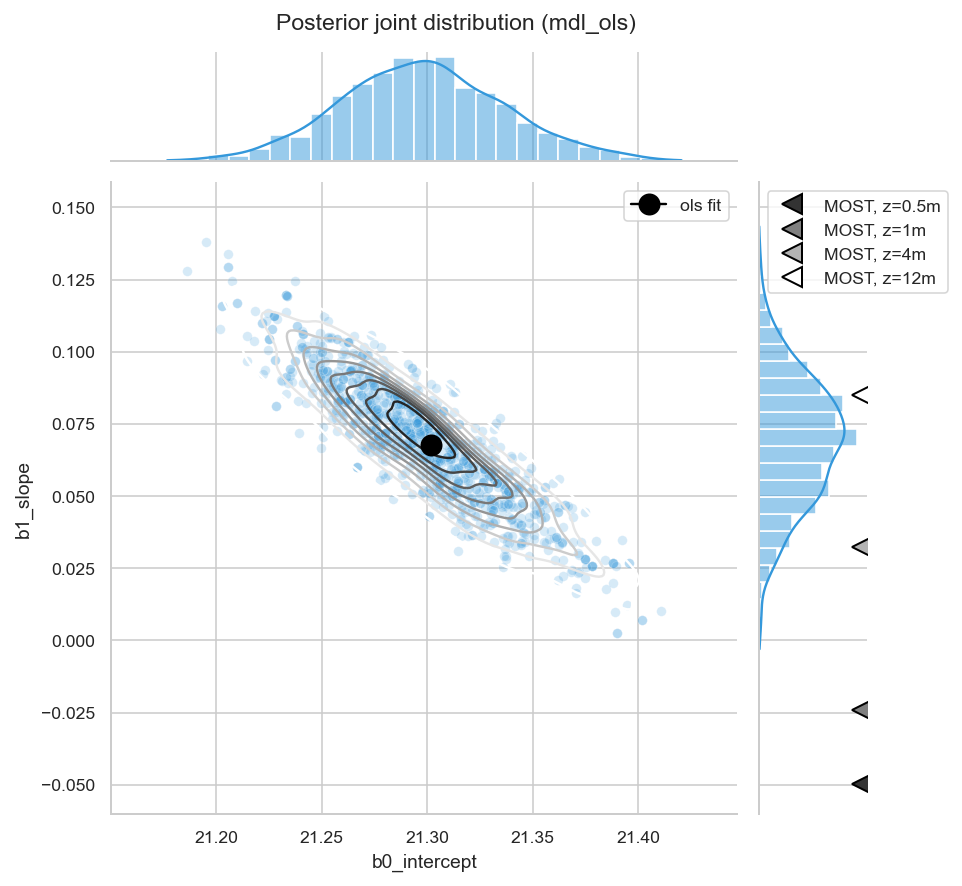

In [23]:
df_trc_ols = pm.trace_to_dataframe(trc_ols)
gd = sns.jointplot(
    x="b0_intercept",
    y="b1_slope",
    data=df_trc_ols,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
    color=flatui[0],
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
_ = gd.fig.suptitle("Posterior joint distribution (mdl_ols)", y=1.02)

csat_colors = ['0.2', '0.5', '0.7', '1']
gd.ax_joint.plot(
    ds_bayes_GLM['ols_b'].values,
    ds_bayes_GLM["ols_m"].values,
    marker='o',
    color='k',
    label='ols fit',
    markersize=10
)

_, xloc = gd.ax_marg_y.get_xlim()

for n, names in enumerate(b1_most.names):
    gd.ax_marg_y.plot(
        xloc,
        b1_most.sel(names=names),
        linestyle='None',
        marker='<',
        markeredgecolor='k',
        markeredgewidth=1,
        color=csat_colors[n],
        label='MOST, z={}'.format(names.values),
        markersize=10)
gd.ax_joint.legend()
gd.ax_marg_y.legend()

In [24]:
print('OLS slope:')
print(ds_bayes_GLM["ols_m"].values)

OLS slope:
0.06774970640844576


So here we can see that the slope uncertainty is actually non-negligible and that the mean slope is not quite zero, which is not too far from what I estimated using the typical ordinary least squares fitting approach.

## 5.2 Same thing but using the T-student likelihood distribution instead of a normal distribution

### Build the GLM

In [25]:
x = ds_bayes_GLM.lnz
y = ds_bayes_GLM.theta_mean

with pm.Model() as mdl_studentt:

    # define weakly informative Normal priors to give Ridge regression
    # I want the model to search for an intercept temperature close to what I can estimate
    b0 = pm.Normal("b0_intercept", mu=b0_guess.values, sigma=1)
    # I don't want the model searching for a slope far away from the initial guess
    b1 = pm.Normal("b1_slope", mu=b1_guess.values, sigma=0.5)
    # define linear model
    y_est = b0 + b1 * x

    # define prior for StudentT degrees of freedom
    # The student t I fit above used a Gamma dist. for degrees of freedom:
    # it's continuous and has support x ∈ (0, inf)
    # I can use the dof defined previously as a starting point.
    # There are two ways to define the distribution:
    #    1) alpha and beta parameters
    #    2) a mean and standard deviation
    # I will use option 2 since I estimated the dof directly, which should
    # correspond to the mean of the distribution.
    nu = pm.Gamma(
        "nu",
        mu=param_studentt[0],
        sigma=2)
   
    # define Student T likelihood
    # The "scale" parameter is given from the above analysis
    likelihood = pm.StudentT(
        "likelihood",
        mu=y_est,
        sigma=param_studentt[2],
        nu=nu,
        observed=y.values)

### Run the GLM

In [26]:
with mdl_studentt:
    trc_studentt = pm.sample(
        tune=5000,
        draws=500,
        chains=2,
        cores=2,
        init="advi+adapt_diag",
        n_init=50000,
        progressbar=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 11.069:  38%|███▊      | 18814/50000 [00:03<00:04, 6558.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:05<00:00, 2029.18draws/s]


### Visualize model results

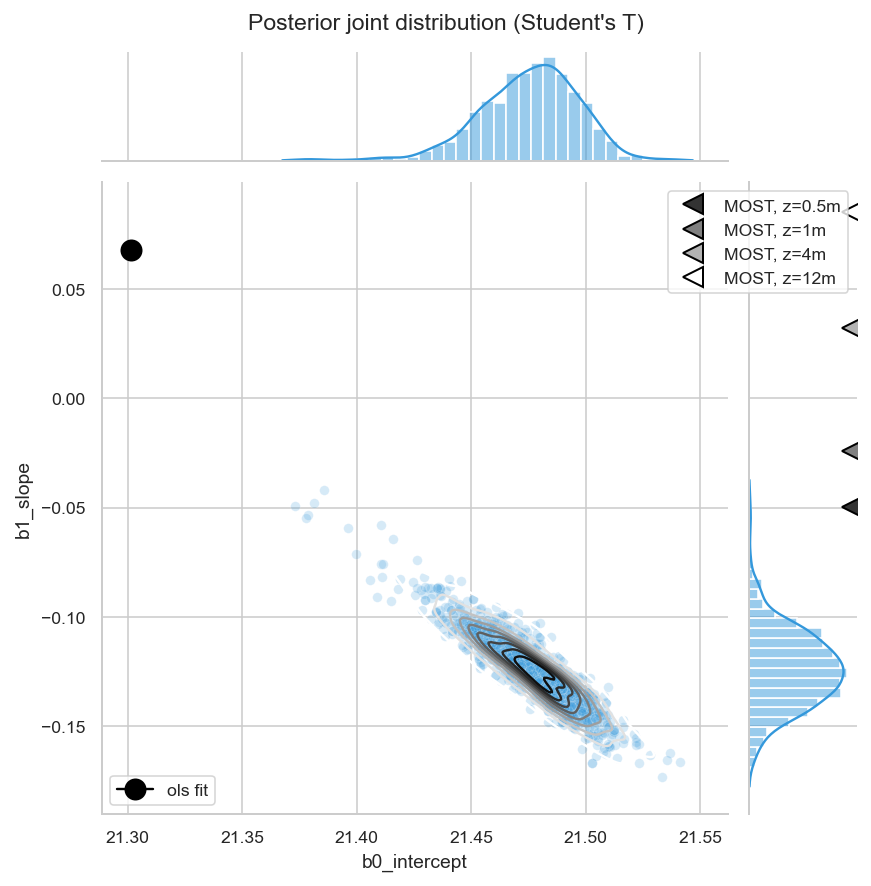

In [43]:
df_trc_studentt = pm.trace_to_dataframe(trc_studentt)
gd = sns.jointplot(
    x="b0_intercept",
    y="b1_slope",
    data=df_trc_studentt,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
    color=flatui[0],
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
_ = gd.fig.suptitle("Posterior joint distribution (Student's T)", y=1.02)

csat_colors = ['0.2', '0.5', '0.7', '1']
gd.ax_joint.plot(
    ds_bayes_GLM['ols_b'].values,
    ds_bayes_GLM["ols_m"].values,
    marker='o',
    color='k',
    label='ols fit',
    markersize=10
)

_, xloc = gd.ax_marg_y.get_xlim()

for n, names in enumerate(b1_most.names):
    gd.ax_marg_y.plot(
        xloc,
        b1_most.sel(names=names),
        linestyle='None',
        marker='<',
        markeredgecolor='k',
        markeredgewidth=1,
        color=csat_colors[n],
        label='MOST, z={}'.format(names.values),
        markersize=10)
gd.ax_joint.legend(loc='lower left')
gd.ax_marg_y.legend()

The GLM using a prior estimate as a Student's distribution provides a tighter distribution of slope parameters than the ordinary least squares fit, which assumes a normally distributed variable. Further, there is a sign agreement between the sonic anemometers in the bottom of the profile and the slope.

### 5.3 Hoggs Inlier vs Outlier classifier

I can take this even further by adding a classifier that either excludes points (outliers) or includes points (inliers). This should help with identifying where/when artifacts occur. I am explicitly stealing the code from here: https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html

Additional references:

The original pdf:
https://cosmo.nyu.edu/hogg/research/2010/08/17/straightline.pdf

A paper that uses the improved fitting from excluding Bayes derived outliers:
https://academic.oup.com/mnras/article/442/4/3380/1355552

The very broad brushstroke of the method is that it builds a liklihood model based on a Bernoulli distribution. Points are more likely to be outliers when the uncertainty in the linear fitting paramters decreases.

_Important note_: I am abusing the inlier classifier. The reality is that there are often physical sublayers present and that we want to model those explicitly including the height of the slope change, indicating the transition between sublayers. For this purpose something like a Bayes Gaussian Process changepoint modeling would be more appropriate. This is future work. 

### Build the model

In [28]:
x = ds_bayes_GLM.lnz
y = ds_bayes_GLM.theta_mean

with pm.Model() as mdl_hogg:

    # state input data as Theano shared vars
    tsv_x = pm.Data("tsv_x", x.values)  # (n, )
    tsv_y = pm.Data("tsv_y", y.values)  # (n, )
    tsv_sigma_y = pm.Data("tsv_sigma_y", param_studentt[2])  # (1, )

    # weakly informative Normal priors (L2 ridge reg) for inliers
    # I want the model to search for an intercept temperature close to what I can estimate
    b0 = pm.Normal("b0_intercept", mu=b0_guess.values, sigma=0.5, testval=pm.floatX(0.0))
    # I don't want the model searching for a slope far away from the initial guess
    b1 = pm.Normal("b1_slope", mu=b1_guess.values, sigma=0.5, testval=pm.floatX(1.0))

    # linear model for mean for inliers
    y_est_in = b0 + b1 * tsv_x  # (n, )

    # very weakly informative mean for all outliers
    y_est_out = pm.Normal("y_est_out", mu=0, sigma=0.6, testval=pm.floatX(0.0))  # (1, )

    # very weakly informative prior for additional variance for outliers
    # The physical interpretation here is that points impacted by artifacts may have
    # a different variance than points impacted by just the atmosphere
    sigma_y_out = pm.HalfNormal("sigma_y_out", sigma=1, testval=pm.floatX(1.0))  # (1, )

    # create in/outlier distributions to get a logp evaluated on the observed y
    # this is not strictly a pymc3 likelihood, but behaves like one when we
    # evaluate it within a Potential (which is minimised)
    inlier_logp = pm.Normal.dist(mu=y_est_in, sigma=tsv_sigma_y).logp(tsv_y)

    outlier_logp = pm.Normal.dist(mu=y_est_out, sigma=tsv_sigma_y + sigma_y_out).logp(tsv_y)

    # frac_outliers only needs to span [0, .5]
    # testval for is_outlier initialised in order to create class asymmetry
    frac_outliers = pm.Uniform("frac_outliers", lower=0.0, upper=0.5)
    is_outlier = pm.Bernoulli(
        "is_outlier",
        p=frac_outliers,
        shape=tsv_x.eval().shape[0],
        testval=(np.random.rand(tsv_x.eval().shape[0]) < 0.4) * 1,
    )  # (n, )

    # non-sampled Potential evaluates the Normal.dist.logp's
    potential = pm.Potential(
        "obs",
        ((1 - is_outlier) * inlier_logp).sum() + (is_outlier * outlier_logp).sum(),
    )

### Run the model

In [29]:
with mdl_hogg:
    trc_hogg = pm.sample(
        tune=5000,
        draws=500,
        chains=2,
        cores=2,
        init="jitter+adapt_diag",
        nuts={"target_accept": 0.9},
        progressbar=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [frac_outliers, sigma_y_out, y_est_out, b1_slope, b0_intercept]
>BinaryGibbsMetropolis: [is_outlier]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:24<00:00, 450.29draws/s]
The number of effective samples is smaller than 25% for some parameters.


### Visualize the posterior distribution

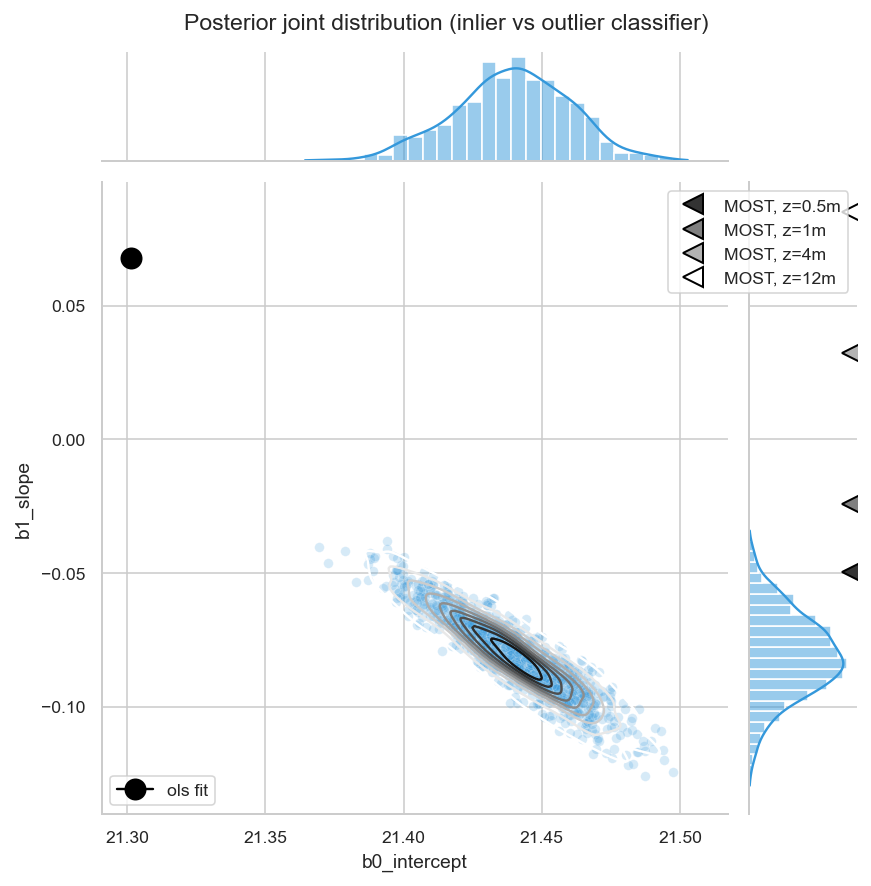

In [41]:
df_trc_hogg = pm.trace_to_dataframe(trc_hogg)
gd = sns.jointplot(
    x="b0_intercept",
    y="b1_slope",
    data=df_trc_hogg,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
    color=flatui[0],
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
_ = gd.fig.suptitle("Posterior joint distribution (inlier vs outlier classifier)", y=1.02)

csat_colors = ['0.2', '0.5', '0.7', '1']
gd.ax_joint.plot(
    ds_bayes_GLM['ols_b'].values,
    ds_bayes_GLM["ols_m"].values,
    marker='o',
    color='k',
    label='ols fit',
    markersize=10
)

_, xloc = gd.ax_marg_y.get_xlim()

for n, names in enumerate(b1_most.names):
    gd.ax_marg_y.plot(
        xloc,
        b1_most.sel(names=names),
        linestyle='None',
        marker='<',
        markeredgecolor='k',
        markeredgewidth=1,
        color=csat_colors[n],
        label='MOST, z={}'.format(names.values),
        markersize=10)
gd.ax_joint.legend(loc='lower left')
gd.ax_marg_y.legend()

### Visualize the inlier/outlier probability

Text(0.5, 1.04, 'For each datapoint, distribution of outlier classification\n over n=11000 samples')

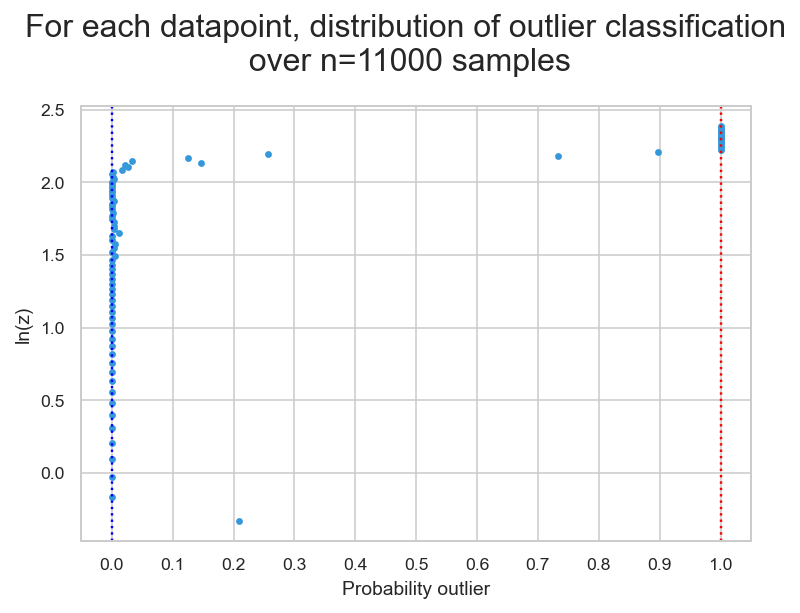

In [31]:
df_outlier_results = pd.DataFrame.from_records(trc_hogg["is_outlier"], columns=ds.lnz.values)
dfm_outlier_results = pd.melt(df_outlier_results, var_name="datapoint_id", value_name="is_outlier")

fig, ax = plt.subplots(1, 1)

ax.plot(df_outlier_results.mean(), df_outlier_results.columns, marker='.', linestyle='None')
ax.set(xlim=(-0.05, 1.05), xticks=np.arange(0, 1.1, 0.1))
ax.axvline(x=0, color="b", linestyle=":")
ax.axvline(x=1, color="r", linestyle=":")
ax.set_ylabel('ln(z)')
ax.set_xlabel('Probability outlier')
fig.suptitle(
    ("For each datapoint, distribution of outlier classification\n over n=11000 samples"),
    y=1.04,
    fontsize=16,
)

In [32]:
cutoff = 0.05
ds_bayes_GLM.coords["classed_as_outlier"] = (('xyz'), np.quantile(trc_hogg["is_outlier"], cutoff, axis=0) == 1)
print('Number of Outliers={}'.format(ds_bayes_GLM["classed_as_outlier"].sum().values))

Number of Outliers=14


## 5.4 Compare all three Bayes GLM

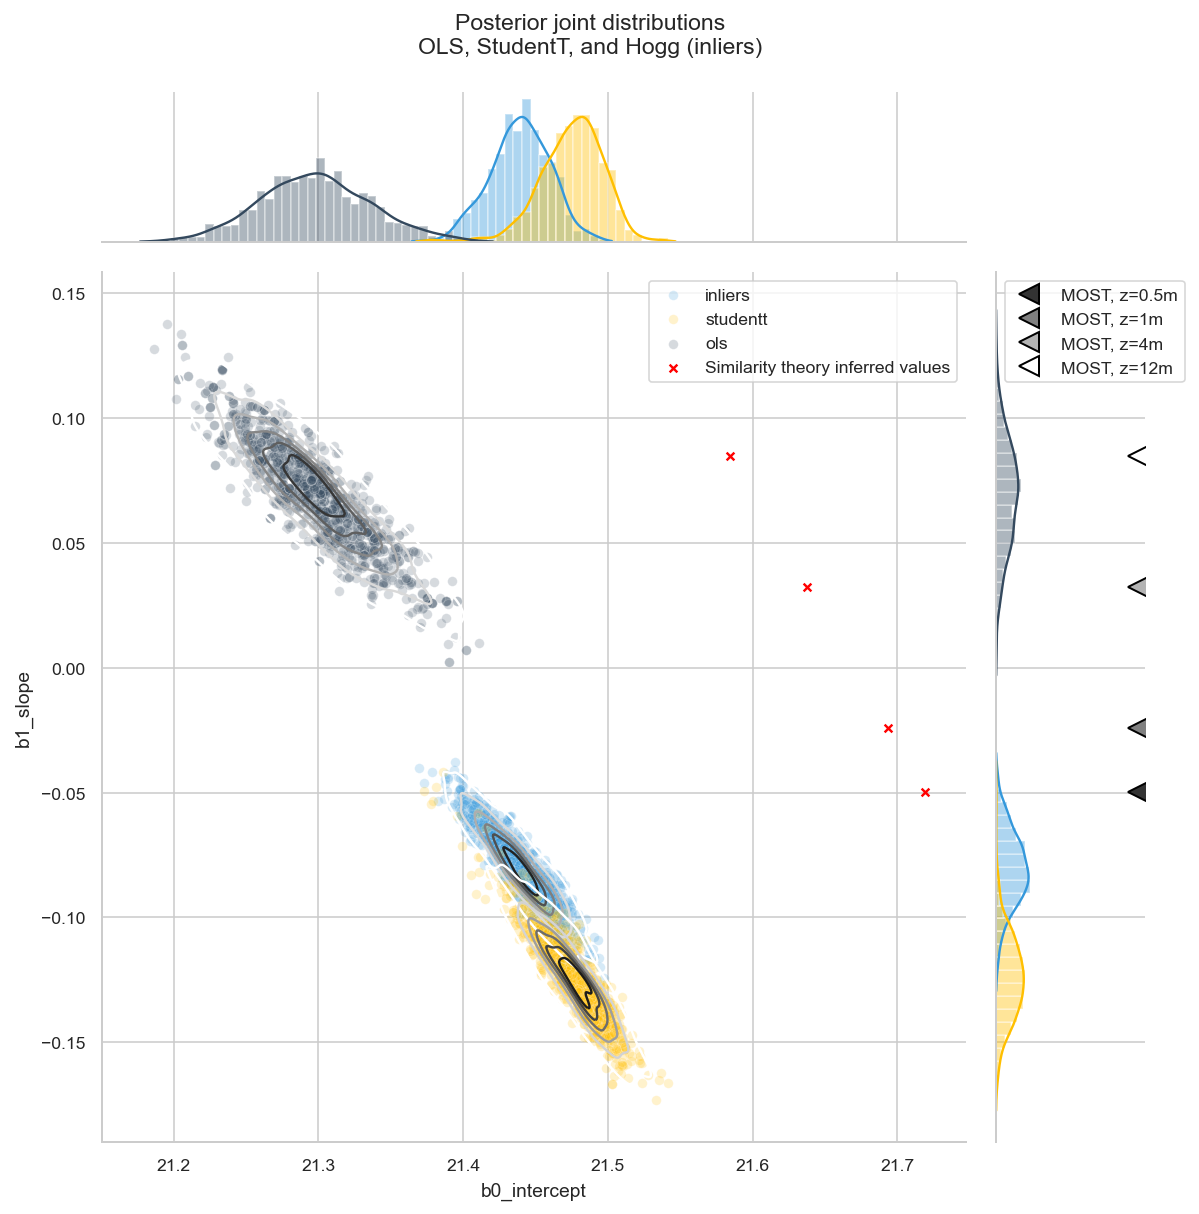

In [42]:
fts = ["b0_intercept", "b1_slope"]
df_trc = pd.concat((df_trc_ols[fts], df_trc_studentt[fts], df_trc_hogg), sort=False)
df_trc["model"] = pd.Categorical(
    np.repeat(["ols", "studentt", "inliers"], len(df_trc_ols)),
    categories=["inliers", "studentt", "ols"],
    ordered=True,
)

gd = sns.JointGrid(x="b0_intercept", y="b1_slope", data=df_trc, height=8)
_ = gd.fig.suptitle(
    ("Posterior joint distributions" + "\nOLS, StudentT, and Hogg (inliers)"), y=1.05
)

_, x_bin_edges = np.histogram(df_trc["b0_intercept"], 60)
_, y_bin_edges = np.histogram(df_trc["b1_slope"], 60)

kde_kws = dict(zorder=2, n_levels=7, cmap="gray_r")
dist_kws = dict(kde_kws=dict(cut=1), axlabel=False)

for num, (idx, grp) in enumerate(df_trc.groupby("model")):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        _ = sns.scatterplot(
            grp["b0_intercept"], grp["b1_slope"], ax=gd.ax_joint, alpha=0.2, label=idx, color=flatui[num]
        )
        _ = sns.kdeplot(grp["b0_intercept"], grp["b1_slope"], ax=gd.ax_joint, color=flatui[num], **kde_kws)
        _ = sns.distplot(
            grp["b0_intercept"], bins=x_bin_edges, ax=gd.ax_marg_x, color=flatui[num], **dist_kws)
        _ = sns.distplot(
            grp["b1_slope"], vertical=True, bins=y_bin_edges, ax=gd.ax_marg_y, color=flatui[num], **dist_kws
        )

gd.ax_joint.scatter(
    b0_most.values, b1_most.values, 15, 'r', marker='x', label='Similarity theory inferred values')
        
for n, names in enumerate(b1_most.names):
    gd.ax_marg_y.plot(
        xloc,
        b1_most.sel(names=names),
        linestyle='None',
        marker='<',
        markeredgecolor='k',
        markeredgewidth=1,
        color=csat_colors[n],
        label='MOST, z={}'.format(names.values),
        markersize=10)
gd.ax_joint.legend()
gd.ax_marg_y.legend()

#### Observations

Oh this is really cool! We have a much better estimate of the temperature gradients to use when comparing to similarity theory now!

The student's t-distribution prior and the Hoggs Inlier models both "de-weight" the upper part of the profile that has a different slope. As mentioned above, this is more abusing the Bayes GLM than modeling the physical process of interest. Regardless, it is a more robust estimate of the stability ($\frac{dT}{d\ln(z)}$) than the standard ols.

The MOST $\theta*$ parameter derived from the CSAT observations are shown in the triangles (right axes) and crosses (joint axes). The MOST slopes are comparable to the log-linear temperature slope from the linear models. The difference is a consequence of the stability functions, which adjust turbulence according to the stability-driven consumption (or enhancement for unstable conditions) of turbulence. The intercept term, which includes the surface roughness term, are well outside the GLM's posterior distributions.

### Visualize the actual distribution of linear fits

Text(0.5, 1.04, 'Tower DTS with posterior predictive fit for 3 models: \n OLS, StudentT and inlier/outlier')

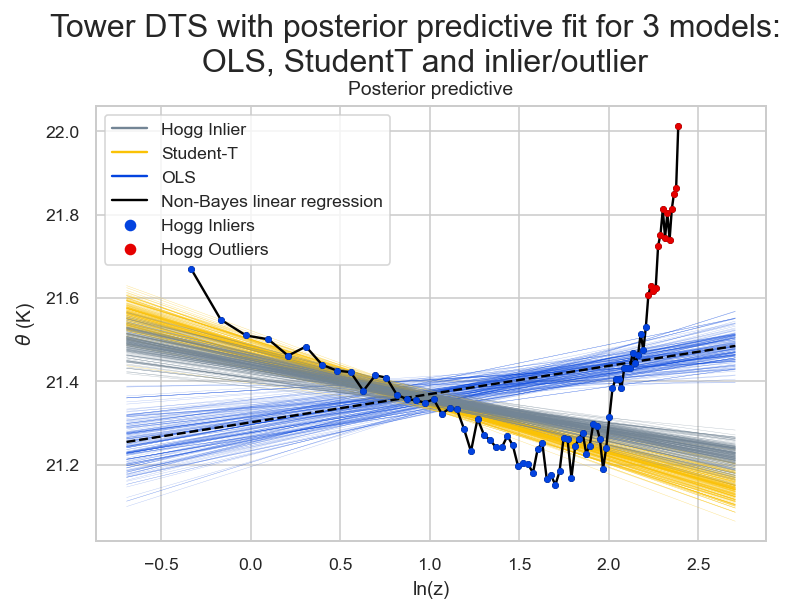

In [34]:
lnz_eval = np.arange(np.log(0.5), np.log(15), 0.01)

fig, ax = plt.subplots(1, 1)

# plot the 3 model (inlier) posterior distributions
lm = lambda x, s: s["b0_intercept"] + s["b1_slope"] * x

pm.plot_posterior_predictive_glm(
    trc_ols,
    lm=lm,
    eval=lnz_eval,
    samples=200,
    color='xkcd:blue',
    alpha=0.3,
)

pm.plot_posterior_predictive_glm(
    trc_studentt,
    lm=lm,
    eval=lnz_eval,
    samples=200,
    color='xkcd:goldenrod',
    alpha=0.5,
)

pm.plot_posterior_predictive_glm(
    trc_hogg,
    lm=lm,
    eval=lnz_eval,
    samples=200,
    color='xkcd:steel',
    alpha=0.5,
)

ax.plot(
    lnz_eval,
    ds_bayes_GLM['ols_m'].values * lnz_eval + ds_bayes_GLM['ols_b'].values,
    'k--',
)

ax.plot(
    ds_bayes_GLM.lnz.values,
    ds_bayes_GLM.theta_mean,
    color='k',
    marker='.'
)

ax.plot(
    ds_bayes_GLM.lnz.values,
    ds_bayes_GLM.theta_mean.where(ds_bayes_GLM.classed_as_outlier == 0),
    color='xkcd:blue',
    marker='.',
    linestyle='None',
)

ax.plot(
    ds_bayes_GLM.lnz.values,
    ds_bayes_GLM.theta_mean.where(ds_bayes_GLM.classed_as_outlier == 1),
    color='xkcd:red',
    marker='.',
    linestyle='None',
)


line_legend = [
        Line2D([0], [0], color='xkcd:steel', label="Hogg Inlier"),
        Line2D([0], [0], color='xkcd:goldenrod', label="Student-T"),
        Line2D([0], [0], color='xkcd:blue', label="OLS"),
        Line2D([0], [0], color='k', label="Non-Bayes linear regression"),
        Line2D([0], [0], marker='o', color='xkcd:blue', label='Hogg Inliers', linestyle='None'),
        Line2D([0], [0], marker='o', color='xkcd:red', label='Hogg Outliers', linestyle='None'),
]
ax.legend(handles=line_legend)
ax.set_ylabel(r'$\theta$ (K)')
ax.set_xlabel('ln(z)')

# create xlims ylims for plotting
fig.suptitle(
    (
        "Tower DTS with posterior predictive fit for 3 models: \n OLS, StudentT and inlier/outlier"
    ),
    y=1.04,
    fontsize=16,
)

Clearly the ability to "choose" to model only one part of the profile (Bayes student's t and Hoggs) instead of the entire profile (ols) gives a much better representation of the stability for the majority of the profile.

# 6. Create a time series of a more robustly estimated temperature gradient

After all of that, let's wrap up these estimates for the entire field campagin.

The Hoggs inlier method is a bit sensitive to the starting priors and takes much longer to run. So to estimate stability for the entire campaign, I will instead use the Student's t-distribution priors and the 1.25m height CSAT derived quantities as initial values.

In [45]:
# Only run this when I have 12 hours to spare
GLM_studentt = False
if GLM_studentt:
    draws = np.arange(0, 1000)
    tower_10min.coords['draws'] = draws
    tower_10min['b0_intercept'] = (('time', 'draws'), np.zeros((len(tower_10min.time), 1000)))
    tower_10min['b1_slope'] = (('time', 'draws'), np.zeros((len(tower_10min.time), 1000)))

    for nt, t in enumerate(tower_10min.time):
        print(pd.Timestamp(t.values))

        # Data for this interval
        ds_sonic = sonic_10min_sub.sel(time=t)
        ds_glm_t = tower_10min.sel(time=t)
        x = ds_glm_t.lnz
        y = ds_glm_t.theta_mean

        # Estimate priors
        z0_t_est, _, _, _ = yang_08(
            ds_sonic['u*'].sel(names='1m').values,
            ds_sonic.wTs.sel(names='1m').values,
            z0,
            y.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest').values,
            1.)

        theta_star = (ds_sonic.wTs / ds_sonic['u*'])
        theta_star_profile_avg = theta_star.mean(dim='names').values

        b0_most = y.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest')
        b1_most = theta_star / (0.4 * np.log(z0_t_est))

        b1_guess = b1_most.sel(names='1m')
        b0_guess = b0_most

        with pm.Model() as mdl_studentt:

            # define weakly informative Normal priors to give Ridge regression
            # I want the model to search for an intercept temperature close to what I can estimate
            b0 = pm.Normal("b0_intercept", mu=b0_guess.values, sigma=3)
            # I don't want the model searching for a slope far away from the initial guess
            b1 = pm.Normal("b1_slope", mu=b1_guess.values, sigma=3)
            # define linear model
            y_est = b0 + b1 * x

            # define prior for StudentT degrees of freedom
            # The student t I fit above used a Gamma dist. for degrees of freedom:
            # it's continuous and has support x ∈ (0, inf)
            # I can use the dof defined previously as a starting point.
            # There are two ways to define the distribution:
            #    1) alpha and beta parameters
            #    2) a mean and standard deviation
            # I will use option 2 since I estimated the dof directly, which should
            # correspond to the mean of the distribution.
            nu = pm.Gamma(
                "nu",
                mu=param_studentt[0],
                sigma=2)

            # define Student T likelihood
            # The "scale" parameter is given from the above analysis
            likelihood = pm.StudentT(
                "likelihood",
                mu=y_est,
                sigma=param_studentt[2],
                nu=nu,
                observed=y.values)

            trc_studentt = pm.sample(
                tune=5000,
                draws=500,
                chains=2,
                cores=2,
                init="advi+adapt_diag",
                n_init=50000,
                progressbar=False,
            )

            df_out = pm.trace_to_dataframe(trc_studentt)
            df_out.index.rename('draws', inplace=True)

            tower_10min['b0_intercept'].loc[dict(time=t)] = df_out['b0_intercept']
            tower_10min['b1_slope'].loc[dict(time=t)] = df_out['b1_slope']

    os.chdir(os.path.join(dir_pre, 'love_dts', 'bayes_glm'))
    tower_10min.to_netcdf('tower_10min_bayes_glm.nc')